# **Imports and Downloads**

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4 --upgrade --force-reinstall --quiet
!pip install --upgrade pennylane pennylane-lightning

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 101.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.7 MB/s eta 0:00:00

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [3]:
# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

import numpy as np
import pandas as pd
import pickle
import math
import re
import os
import random
import time
import matplotlib.pyplot as plt
from collections import Counter

# Quantum computing
import pennylane as qml
from pennylane import draw
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer

# NLP and preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
pnp.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# **Data Loading and Preprocessing**

In [4]:
with open("/content/drive/MyDrive/QML-Research/Data/sentiment labelled sentences/amazon_cells_labelled.txt", "r") as f:
    lines = f.readlines()

sentences = [line.split("\t")[0] for line in lines]
labels = [int(line.split("\t")[1]) for line in lines]

In [5]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
domain_neutral_words = {
    "phone", "product", "battery", "headset", "quality", "one", "use"
}
stop_words.update(domain_neutral_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

cleaned_sents = [clean_and_tokenize(sentence) for sentence in sentences]

In [7]:
max_len = 10
for i in range(len(cleaned_sents)):
  if (len(cleaned_sents[i]) < max_len):
    cleaned_sents[i] += ["<PAD>"] * (max_len - len(cleaned_sents[i]))
  else:
    cleaned_sents[i] = cleaned_sents[i][:max_len]

# **GloVE Word Embeddings**

In [8]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [9]:
glove_path = '/content/drive/MyDrive/QML-Research/Data/glove.6B.100d.txt'
glove = load_glove_embeddings(glove_path)

# **AutoEncoder**

In [10]:
class GloVeAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(GloVeAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
all_words = list(glove.keys())
all_vectors = np.array([glove[word] for word in all_words])
all_vectors = normalize(all_vectors)
word_tensor = torch.tensor(all_vectors).float()

In [12]:
latent_dim = 4
epochs = 100
save_path = '/content/drive/MyDrive/QML-Research/Autoencoder/glove_autoencoder_normalized_4.pth'

In [13]:
if os.path.exists(save_path):
    print(f"Loading Autoencoder from {save_path}")
    autoencoder = GloVeAutoencoder(input_dim=100, latent_dim=latent_dim)
    autoencoder.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
else:
    print("Training Autoencoder")
    autoencoder = GloVeAutoencoder(input_dim=100, latent_dim=latent_dim)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        reconstructed = autoencoder(word_tensor)
        loss = criterion(reconstructed, word_tensor)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    torch.save(autoencoder.state_dict(), save_path)
    print(f"Saved Autoencoder serialized model in drive @ {save_path}")

Loading Autoencoder from /content/drive/MyDrive/QML-Research/Autoencoder/glove_autoencoder_normalized_4.pth


In [14]:
autoencoder.eval()
with torch.no_grad():
    compressed_vectors = autoencoder.encoder(word_tensor).numpy()

reduced_embeddings = {
    word: compressed_vectors[i]
    for i, word in enumerate(all_words)
}

# **Embedding**

In [15]:
def sentence_to_vec(sentence, embeddings, dim):
    vectors = []
    for word in sentence:
        if word in embeddings:
            vectors.append(embeddings[word])
        else:
            vectors.append(np.zeros(dim))
    return vectors

def embed_sentences(cleaned_sents, embeddings, dim):
    return np.array([sentence_to_vec(tokens, embeddings, dim) for tokens in cleaned_sents])

In [16]:
X_embed_np = embed_sentences(cleaned_sents, reduced_embeddings, dim=4)
X_embed_np = (X_embed_np - X_embed_np.min()) * (np.pi / (X_embed_np.max() - X_embed_np.min()))

X_embed = torch.tensor(X_embed_np).float()
y_embed = torch.tensor(labels).long()

# **Dataset and DataLoader**

In [17]:
class AmazonDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_embed, y_embed, test_size=0.2, stratify=y_embed.numpy(), random_state=42
)

train_dataset = AmazonDataset(X_train, y_train)
test_dataset = AmazonDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

# **Utility Functions**

In [19]:
def softmax(logits):
    logits = qml.numpy.array(logits)
    logits = logits - qml.numpy.max(logits)
    exps = qml.numpy.exp(logits)
    return exps / qml.numpy.sum(exps)

def cross_entropy(label, probs):
    p = qml.numpy.clip(probs[label], 1e-10, 1.0)
    return -qml.numpy.log(p)

# **QRNN Model Layers**

In [20]:
def angle_embed_4(word_vec, input_wires):
    for i, w in enumerate(input_wires):
        qml.RY(word_vec[i], wires=w)

def entangle_1to1(inp_wires, hid_wires):
    for i in range(len(inp_wires)):
        qml.CNOT(wires=[inp_wires[i], hid_wires[i]])

def qrnn_layer_expressive(weightsA, weightsB, cry_weights, hid_wires):
    n = len(hid_wires)

    for i, w in enumerate(hid_wires):
        # qml.RX(weightsA[i, 0], wires=w)
        qml.RY(weightsA[i], wires=w)
        # qml.RZ(weightsA[i, 2], wires=w)

    for i in range(n):
        c = hid_wires[i]
        t = hid_wires[(i + 1) % n]
        qml.CRY(cry_weights[i], wires=[c, t])

    for i, w in enumerate(hid_wires):
        # qml.RX(weightsB[i, 0], wires=w)
        qml.RY(weightsB[i], wires=w)
        # qml.RZ(weightsB[i, 2], wires=w)

# **Model**

In [21]:
INPUT_WIRES  = [0, 1, 2, 3]
HIDDEN_WIRES = [4, 5, 6, 7]
READ_WIRES   = [6, 7]

In [22]:
def qrnn_model_sequence(x_sequence, flat_params):
    n_hid = 4
    n_cls = 2

    L = n_hid
    per_layer = 2 * L
    C = n_cls * 3

    o = 0
    w_l1_A = flat_params[o:o+L].reshape((n_hid,)); o += L
    w_l1_B = flat_params[o:o+L].reshape((n_hid,)); o += L
    w_l1_CRY = flat_params[o:o+n_hid]; o += n_hid
    w_l2_A = flat_params[o:o+L].reshape((n_hid,)); o += L
    w_l2_B = flat_params[o:o+L].reshape((n_hid,)); o += L
    w_l2_CRY = flat_params[o:o+n_hid]; o += n_hid
    w_l3_A = flat_params[o:o+L].reshape((n_hid,)); o += L
    w_l3_B = flat_params[o:o+L].reshape((n_hid,)); o += L
    w_l3_CRY = flat_params[o:o+n_hid]; o += n_hid

    w_cls   = flat_params[o:o+C].reshape((n_cls, 3)); o += C
    w_extra = flat_params[o:o+C].reshape((n_cls, 3)); o += C

    for word_vec in x_sequence:
        angle_embed_4(word_vec, INPUT_WIRES)
        entangle_1to1(INPUT_WIRES, HIDDEN_WIRES)
        qrnn_layer_expressive(w_l1_A, w_l1_B, w_l1_CRY, HIDDEN_WIRES)
        qrnn_layer_expressive(w_l2_A, w_l2_B, w_l2_CRY, HIDDEN_WIRES)
        qrnn_layer_expressive(w_l3_A, w_l3_B, w_l3_CRY, HIDDEN_WIRES)
        entangle_1to1(HIDDEN_WIRES[:2], HIDDEN_WIRES[2:])

    entangle_1to1(HIDDEN_WIRES[:2], HIDDEN_WIRES[2:])

    for i, w in enumerate(READ_WIRES):
        qml.Rot(w_cls[i, 0], w_cls[i, 1], w_cls[i, 2], wires=w)

    for i, w in enumerate(READ_WIRES):
        qml.Rot(w_extra[i, 0], w_extra[i, 1], w_extra[i, 2], wires=w)

# **QNode**

In [23]:
n_qubits = 8
dev_train = qml.device("lightning.qubit", wires=n_qubits)
dev_test = qml.device("lightning.qubit", wires=n_qubits, shots=1000, seed=42)

In [24]:
@qml.qnode(dev_train, interface='autograd')
def qnode_train(x_sequence, flat_params):
    qrnn_model_sequence(x_sequence, flat_params)
    return (qml.expval(qml.PauliZ(READ_WIRES[0])),
            qml.expval(qml.PauliZ(READ_WIRES[1])))

@qml.qnode(dev_test, interface='autograd', diff_method="parameter-shift")
def qnode_test(x_sequence, flat_params):
    qrnn_model_sequence(x_sequence, flat_params)
    return (qml.expval(qml.PauliZ(READ_WIRES[0])),
            qml.expval(qml.PauliZ(READ_WIRES[1])))

# **Parameter Initialization**

In [25]:
params_l1_A = pnp.array(pnp.random.uniform(-0.2, 0.2, size=(4,)), requires_grad=True)
params_l1_B = pnp.array(pnp.random.uniform(-0.2, 0.2, size=(4,)), requires_grad=True)
params_l1_CRY = pnp.array(pnp.random.uniform(-0.2, 0.2, size=(4,)), requires_grad=True)
params_l2_A = pnp.array(pnp.random.uniform(-0.2, 0.2, size=(4,)), requires_grad=True)
params_l2_B = pnp.array(pnp.random.uniform(-0.2, 0.2, size=(4,)), requires_grad=True)
params_l2_CRY = pnp.array(pnp.random.uniform(-0.2, 0.2, size=(4,)), requires_grad=True)
params_l3_A  = pnp.array(pnp.random.uniform(low=-0.2, high=0.2, size=(4,)), requires_grad=True)
params_l3_B = pnp.array(pnp.random.uniform(low=-0.2, high=0.2, size=(4,)), requires_grad=True)
params_l3_CRY = pnp.array(pnp.random.uniform(-0.2, 0.2, size=(4,)), requires_grad=True)

params_classifier = pnp.array(pnp.random.uniform(-0.2, 0.2, size=(2, 3)), requires_grad=True)
params_extra      = pnp.array(pnp.random.uniform(-0.2, 0.2, size=(2, 3)), requires_grad=True)


flat_params = pnp.concatenate([
    params_l1_A.flatten(), params_l1_B.flatten(), params_l1_CRY.flatten(),
    params_l2_A.flatten(), params_l2_B.flatten(), params_l2_CRY.flatten(),
    params_l3_A.flatten(), params_l3_B.flatten(), params_l3_CRY.flatten(),
    params_classifier.flatten(),
    params_extra.flatten()
])
flat_params.requires_grad = True

optimizer = AdamOptimizer(stepsize=0.005)
epochs = 40

# **Training**

In [26]:
train_losses = []
train_accuracies = []

print("Training Loop\n")
start_time = time.time()

for epoch in range(1, epochs + 1):
    epoch_loss = 0
    correct = 0
    total = 0
    epoch_start = time.time()

    for xb, yb in train_loader:
        x_np = xb.squeeze(0).numpy()
        y_np = yb.item()
        x_qml = qml.numpy.array(x_np, requires_grad=False)

        def cost(flat_params):
          logits = qnode_train(x_qml, flat_params)
          probs = softmax(qml.numpy.array(logits))
          return cross_entropy(y_np, probs)

        grad = qml.grad(cost)(flat_params)
        grad_norm = qml.numpy.linalg.norm(grad)
        flat_params = optimizer.step(cost, flat_params)
        logits = qnode_train(x_qml, flat_params)
        probs = softmax(qml.numpy.array(logits))
        loss = cross_entropy(y_np, probs)

        pred_label = qml.numpy.argmax(probs)

        if pred_label == y_np:
            correct += 1
        epoch_loss += loss
        total += 1

    avg_loss = epoch_loss / total
    acc = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch:02d} | Loss: {avg_loss:.4f} | Acc: {acc:.4f} | Grad Norm: {grad_norm:.6f} | Time: {epoch_time:.2f}s")

total_time = time.time() - start_time
print(f"\nTraining complete in {total_time:.2f} seconds.")

Training Loop

Epoch 01 | Loss: 0.7001 | Acc: 0.5075 | Grad Norm: 0.501253 | Time: 154.89s
Epoch 02 | Loss: 0.6906 | Acc: 0.5225 | Grad Norm: 0.516937 | Time: 154.50s
Epoch 03 | Loss: 0.6886 | Acc: 0.5275 | Grad Norm: 0.628995 | Time: 154.21s
Epoch 04 | Loss: 0.6863 | Acc: 0.5637 | Grad Norm: 0.894872 | Time: 156.02s
Epoch 05 | Loss: 0.6872 | Acc: 0.5625 | Grad Norm: 0.619527 | Time: 154.61s
Epoch 06 | Loss: 0.6894 | Acc: 0.5300 | Grad Norm: 0.560830 | Time: 154.69s
Epoch 07 | Loss: 0.6876 | Acc: 0.5563 | Grad Norm: 0.924201 | Time: 156.44s
Epoch 08 | Loss: 0.6872 | Acc: 0.5750 | Grad Norm: 0.708815 | Time: 156.22s
Epoch 09 | Loss: 0.6873 | Acc: 0.5450 | Grad Norm: 0.677282 | Time: 153.31s
Epoch 10 | Loss: 0.6852 | Acc: 0.5525 | Grad Norm: 0.266124 | Time: 153.37s
Epoch 11 | Loss: 0.6872 | Acc: 0.5500 | Grad Norm: 0.393105 | Time: 153.33s
Epoch 12 | Loss: 0.6802 | Acc: 0.5725 | Grad Norm: 0.422465 | Time: 153.73s
Epoch 13 | Loss: 0.6864 | Acc: 0.5387 | Grad Norm: 0.837127 | Time: 153.9

# **Testing**

In [27]:
def evaluate_test(flat_params):
    correct = 0
    total = 0
    test_loss = 0

    for xb, yb in test_loader:
        x_np = xb.squeeze(0).numpy()
        y_np = yb.item()
        x_qml = qml.numpy.array(x_np, requires_grad=False)

        logits = qnode_test(x_qml, flat_params)
        probs = softmax(logits)
        loss = cross_entropy(y_np, probs)

        pred = qml.numpy.argmax(probs)

        if pred == y_np:
            correct += 1
        test_loss += loss
        total += 1

    return test_loss / total, correct / total

# **Logging**

In [40]:
def log_test_results(model_name, test_acc, test_loss):
    log_path = "/content/drive/MyDrive/QML-Research/Analysis/logs/qrnn_outputs/accuracy_logs.txt"

    with open(log_path, "a") as f:
        f.write(f"[Model: {model_name}]\n")
        f.write(f"Test Accuracy: {test_acc:.4f}\n")
        f.write(f"Test Loss: {test_loss:.4f}\n\n")

    print(f"Logged test results to: {log_path}")

In [41]:
def save_training_plots(model_name, train_losses, train_accuracies):
    base_path = "/content/drive/MyDrive/QML-Research/Analysis/plots"

    # Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.title(f"{model_name} - Loss Trend")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{base_path}/loss_trend/loss_plot_{model_name}.png")
    plt.close()

    # Accuracy Plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label="Training Accuracy", color='green')
    plt.title(f"{model_name} - Accuracy Trend")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{base_path}/accuracy_trend/acc_plot_{model_name}.png")
    plt.close()

    print(f"Plots saved to: {base_path}/loss_trend/ and /accuracy_trend/")

In [42]:
test_loss, test_acc = evaluate_test(flat_params)
log_test_results("QRNN_Sim_v9", test_acc, test_loss)
save_training_plots("QRNN_Sim_v9", train_losses, train_accuracies)

Logged test results to: /content/drive/MyDrive/QML-Research/Analysis/logs/qrnn_outputs/accuracy_logs.txt
Plots saved to: /content/drive/MyDrive/QML-Research/Analysis/plots/loss_trend/ and /accuracy_trend/


In [43]:
# for _ in range(4):
#   test_loss, test_acc = evaluate_test(flat_params)
#   log_test_results("QRNN_Sim_diff_seed", test_acc, test_loss)

# **Model Saving and Loading**

In [32]:
with open('/content/drive/MyDrive/QML-Research/Model Saves/QRNN_Sim_v9.pkl', 'wb') as f:
    pickle.dump(flat_params, f)

print("Saved Model parameters")

Saved Model parameters


In [ ]:
# with open('/content/drive/MyDrive/QML-Research/Model Saves/QRNN_Sim_v6.pkl', 'rb') as f:
#     flat_params = pickle.load(f)

# print("Model parameters loaded")

Model parameters loaded


# **Test Inference**

In [33]:
trial_sentences = [
    "This charger is amazing, super fast and highly reliable.",
    "Worst headphones ever bought, awful sound and terrible build quality.",
    "Very satisfied with camera quality considering the affordable price range.",
    "Product stopped working completely within one week of regular usage.",
    "Excellent screen resolution, great brightness and strong battery backup too.",
    "This is the best light bulb I’ve ever used.",
    "Did not match the description, complete waste of my money.",
    "This chair feels sturdy, comfortable, and worth every single penny.",
    "Absolutely love this phone case, protective, stylish and well-made.",
    "Speaker quality is poor, distorts quickly at medium volume levels.",
    "Delivery arrived quickly with excellent packaging and no visible damages.",
    "Avoid this item entirely, cheap build and constantly stops working.",
    "Best pair of scissors ever purchased, sharp, durable and reliable."
]

def preprocess_for_inference(sent_list):
    encoded_sents = []

    for sentence in sent_list:
        tokens = clean_and_tokenize(sentence)
        if len(tokens) < max_len:
            tokens += ["<PAD>"] * (max_len - len(tokens))
        else:
            tokens = tokens[:max_len]

        vec = sentence_to_vec(tokens, reduced_embeddings, dim=4)
        vec = np.array(vec)
        vec = (vec - X_embed_np.min()) * (np.pi / (X_embed_np.max() - X_embed_np.min()))
        encoded_sents.append(vec)

    return encoded_sents

encoded_inputs = preprocess_for_inference(trial_sentences)

for sent, input_vec in zip(trial_sentences, encoded_inputs):
    x_qml = qml.numpy.array(input_vec, requires_grad=False)
    logits = qnode_test(x_qml, flat_params)
    probs = softmax(logits)
    pred = qml.numpy.argmax(probs)

    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"Sentence: \"{sent}\"\nPredicted Sentiment: {sentiment} ({pred})\n")

Sentence: "This charger is amazing, super fast and highly reliable."
Predicted Sentiment: Positive (1)

Sentence: "Worst headphones ever bought, awful sound and terrible build quality."
Predicted Sentiment: Positive (1)

Sentence: "Very satisfied with camera quality considering the affordable price range."
Predicted Sentiment: Positive (1)

Sentence: "Product stopped working completely within one week of regular usage."
Predicted Sentiment: Positive (1)

Sentence: "Excellent screen resolution, great brightness and strong battery backup too."
Predicted Sentiment: Positive (1)

Sentence: "This is the best light bulb I’ve ever used."
Predicted Sentiment: Positive (1)

Sentence: "Did not match the description, complete waste of my money."
Predicted Sentiment: Positive (1)

Sentence: "This chair feels sturdy, comfortable, and worth every single penny."
Predicted Sentiment: Positive (1)

Sentence: "Absolutely love this phone case, protective, stylish and well-made."
Predicted Sentiment: Posi

# **Circuit**

In [34]:
x_sample = pnp.random.rand(10, 4)
params_sample = pnp.random.uniform(-0.2, 0.2, size=(48,), requires_grad=True)
drawer = qml.draw(qnode_train)
print(drawer(x_sample, params_sample))

0: ──RY(0.57)─╭●──RY(0.40)─────────────────────────────────────────────────────────────── ···
1: ──RY(0.03)─│──╭●─────────RY(0.93)───────────────────────────────────────────────────── ···
2: ──RY(0.84)─│──│─────────╭●─────────RY(0.73)─────────────────────────────────────────── ···
3: ──RY(0.45)─│──│─────────│─────────╭●─────────RY(0.33)───────────────────────────────── ···
4: ───────────╰X─│─────────│─────────│──────────RY(0.02)──╭●───────────────────────────── ···
5: ──────────────╰X────────│─────────│──────────RY(-0.05)─╰RY(0.08)─╭●─────────────────── ···
6: ────────────────────────╰X────────│──────────RY(0.19)────────────╰RY(-0.16)─╭●──────── ···
7: ──────────────────────────────────╰X─────────RY(0.14)───────────────────────╰RY(-0.02) ···

0: ··· ──────────────────────────────────────────────────────────────────────────────────── ···
1: ··· ──────────────────────────────────────────────────────────────────────────────────── ···
2: ··· ────────────────────────────────────────────────

(<Figure size 23900x900 with 1 Axes>, <Axes: >)

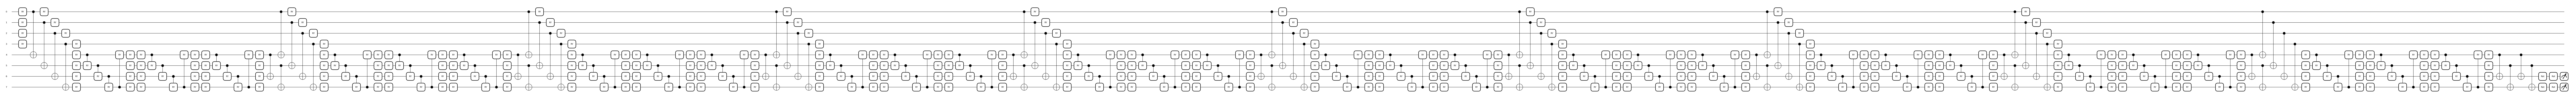

In [35]:
qml.draw_mpl(qnode_train)(x_sample, params_sample)